In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
# import wget
# from math import cos, sin, pi, sqrt
# from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples
import plotly.express as px
import os
import matplotlib.ticker as mticker

## Import Cartopy stuff.
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from geographiclib.geodesic import Geodesic

# Performing a Cluster Analysis on TC Genesis

## Definning Functions

In [6]:
def compute_distance(data, centers, k):
    """
    """
    # Initialize distance
    distance = np.zeros((np.shape(data)[0], k))
    # Loop on n data points
    for i in range(0, np.shape(data)[0]):
        # Loop on k centroids
        for j in range(0, k):
            # Compute distance
            distance[i, j] = np.sqrt(np.sum(np.square(data[i, :] - centers[j, :])))
    return distance

def compute_elbow(data, clusters, centers, k):
    """
    """
    E = 0
    for i in range(0, k):
        distance = compute_distance(data[clusters == i, :], centers[i, :].reshape(1, -1), 1)
        E = E + np.mean(np.square(distance))
    return E

def init_centers(data, k):
    """
    """
    # Initialize centroids
    centers = np.zeros((k, np.shape(data)[1]))
    # Loop on k centers
    for i in range(0, k):
        # Generate p random values between 0 and 1
        dist = np.random.uniform(size=np.shape(data)[1])
        # Use the random values to generate a point within the range of values taken by the data
        centers[i, :] = np.min(data, axis=0) + (np.max(data, axis=0) - np.min(data, axis=0)) * dist
    return centers

def compute_clusters(distance):
    """
    """
    # Initialize clusters
    clusters = np.zeros(np.shape(distance)[0])
    # Loop on n data points
    for i in range(0, np.shape(distance)[0]):
        # Find closest centroid
        best = np.argmin(distance[i, :])
        # Assign data point to corresponding cluster
        clusters[i] = best
    return clusters

def compute_centers(data, clusters, k):
    """
    """
    # Initialize centroids
    centers = np.zeros((k, np.shape(data)[1]))
    # Loop on clusters
    for i in range(0, k):
        # Select all data points in this cluster
        subdata = data[clusters == i, :]
        # If no data point in this cluster, generate randomly a new centroid
        if (np.shape(subdata)[0] == 0):
            centers[i, :] = init_centers(data, 1)
        else:
            # Compute the mean location of all data points in this cluster
            centers[i, :] = np.mean(subdata, axis=0)
    return centers

def compute_objective(distance, clusters):
    """
    """
    # Initialize objective
    objective = 0.0
    # Loop on n data points
    for i in range(0, np.shape(distance)[0]):
        # Add distance to the closest centroid
        objective = objective + distance[i, int(clusters[i])] ** 2.0
    return objective

def my_kmeans(data, k):
    """
    """
    # Initialize centroids
    centers = init_centers(data, k)
    # Initialize objective function to square of the maximum distance between two data points times number of data points
    objective_old = np.shape(data)[0] * np.sum(np.square(np.max(data, axis=0) - np.min(data, axis=0)))
    # Initialize clusters
    clusters_old = np.zeros(np.shape(data)[0])
    # Start loop until convergence
    stop_alg = False
    while stop_alg == False:
        # Compute distance between data points and centroids
        distance = compute_distance(data, centers, k)
        # Get new clusters
        clusters_new = compute_clusters(distance)
        # get new value of objective function
        objective_new = compute_objective(distance, clusters_new)
        # If objective function stops decreasing, end loop
        if objective_new >= objective_old:
            return (clusters_old, objective_old, centers)
        else:
            # Update the locations of the centroids
            centers = compute_centers(data, clusters_new, k)
            objective_old = objective_new
            clusters_old = clusters_new

def repeat_kmeans(data, k, N):
    """
    """
    # Initialization
    objective = np.zeros(N)
    clusters = np.zeros((N, np.shape(data)[0]))
    centers = np.zeros((N, k, np.shape(data)[1]))
    # Run K-means N times
    for i in range(0, N):
        result = my_kmeans(data, k)
        clusters[i, :] = result[0]
        objective[i] = result[1]
        centers[i, :, :] = result[2]
        print(i/N*100)
    # Choose the clustering with the best value of the objective function
    best = np.argmin(objective)
    return (clusters[best, :], objective[best], centers[best, :, :])

In [16]:
PATH = '/home/disk/orca/adaley17/MLGEO2024_TC_Tracks_Intensity/data/'
bt_data = 'clean/cleaned_best_track_data.csv'
ships_data = 'ai_ready/ai_ready_SHIPS_data.csv'

df_SHIPS = pd.read_csv(os.path.join(PATH, ships_data))
df_BT = pd.read_csv(os.path.join(PATH, bt_data))

df_BT.head()

,ISO_TIME,USA_ATCF_ID,NAME,DIST2LAND,LANDFALL,STORM_SPEED,STORM_DIR,USA_LAT,USA_LON,USA_WIND,USA_PRES,USA_RMW,USA_WSPD
0,1982-06-02 12:00:00,AL011982,ALBERTO,22,1.397480e+11,0.953043,47,21.7000,-87.1000,20,1005.0,NaN,10.288880
1,1982-06-02 15:00:00,AL011982,ALBERTO,59,3.747788e+11,1.089192,48,21.9551,-86.8077,22,1004.0,NaN,11.317768
2,1982-06-02 18:00:00,AL011982,ALBERTO,93,5.907529e+11,1.089192,52,22.2000,-86.5000,25,1004.0,NaN,12.861100
3,1982-06-02 21:00:00,AL011982,ALBERTO,130,7.177966e+11,1.089192,58,22.4224,-86.1650,27,1003.0,NaN,13.889988
4,1982-06-03 00:00:00,AL011982,ALBERTO,113,6.225139e+11,1.089192,68,22.6000,-85.8000,30,1003.0,NaN,15.433320


In [17]:
df_SHIPS.head()

,Original_Times,Times,Daily_SST_Avg,Mid_Level_RH,Vert_Vel,Vshear,MSLP,Vmax,Latitude,Longitude
0,1982-06-02 12:00:00,-12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1982-06-02 12:00:00,-6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1982-06-02 12:00:00,0.0,27.1,57.0,6.631183,15.227542,1005.0,10.28888,21.7,87.1
3,1982-06-02 12:00:00,6.0,27.8,53.0,3.966363,15.536209,1004.0,12.86110,22.2,86.5
4,1982-06-02 12:00:00,12.0,27.9,56.0,4.403641,15.330431,1003.0,15.43332,22.6,85.8


In [105]:
genesis_lat_lon = df_BT.groupby('USA_ATCF_ID')[['ISO_TIME', 'USA_LAT', 'USA_LON']].first().reset_index()
print(genesis_lat_lon)

    USA_ATCF_ID             ISO_TIME  USA_LAT  USA_LON
0      AL011982  1982-06-02 12:00:00     21.7    -87.1
1      AL011985  1985-07-15 18:00:00     29.4    -64.2
2      AL011986  1986-06-05 00:00:00     26.2    -75.8
3      AL011988  1988-08-05 18:00:00     32.0    -77.5
4      AL011991  1991-06-29 12:00:00     25.9    -78.0
..          ...                  ...      ...      ...
557    AL312020  2020-11-12 12:00:00     15.5    -70.9
558    EP022013  2013-05-28 12:00:00     13.9    -96.1
559    EP112010  2010-09-03 18:00:00     14.9    -94.1
560    EP131988  1988-10-23 12:00:00     12.5    -87.8
561    EP141993  1993-09-22 00:00:00     20.9   -106.5

[562 rows x 4 columns]


## Visualizing The Genesis Location of each Storm

Text(0.5, 1.0, 'Genesis Location of each Storm')

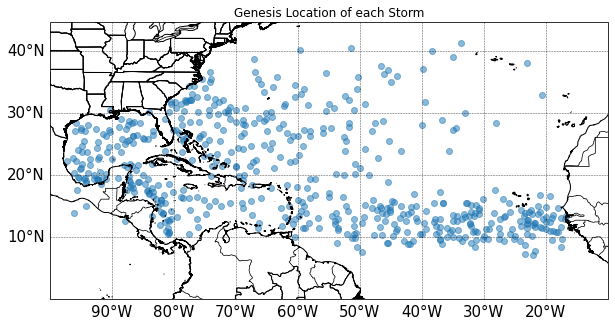

In [106]:
min_lat = 0
max_lat = 35

min_lon = -100
max_lon = -10

proj = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale='high', levels=[1,], edgecolor='k')
lakes = cfeature.GSHHSFeature(scale='high', levels=[2,], edgecolor='face',facecolor='grey')

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.set_extent([min_lon,max_lon, min_lat, max_lat])
ax.add_feature(cfeature.LAND, color='white')
ax.add_feature(cfeature.STATES)
ax.add_feature(coast)
ax.add_feature(cfeature.BORDERS, linewidth=0.75)
states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='110m')

ax.add_feature(states_provinces, linewidth=0.75, edgecolor='k', facecolor='none')


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.5, color='k', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

ax.scatter(genesis_lat_lon['USA_LON'], genesis_lat_lon['USA_LAT'], alpha=0.5)
ax.set_title('Genesis Location of each Storm')


## Elbow Method

We use the elbow method to help us determine the number of clusters

In [107]:
E = np.zeros(8)
for k in range(1, 9):
    (clusters, objective, centers) = my_kmeans(genesis_lat_lon[['USA_LAT', 'USA_LON']].values, k)
    E[k - 1] = compute_elbow(genesis_lat_lon[['USA_LAT', 'USA_LON']].values, clusters, centers, k)

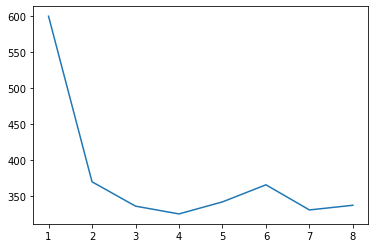

In [108]:
plt.plot(np.arange(1, 9), E)

The elbow method suggests that 4 clusters may be best. The elbow method tends to struggle when data points are close to each other so lets try the silhouette analysis as well.

In [152]:
ncluster=4
genesis_data = genesis_lat_lon[['USA_LAT', 'USA_LON']].values #Selecting the last two columns(Latitude and Longitude)
kmeans_model = KMeans(n_clusters=ncluster, init='k-means++', random_state=1).fit(genesis_data)
labels = kmeans_model.labels_
sc=silhouette_score(genesis_data, labels, metric='euclidean')

In [153]:
kmeans_model.cluster_centers_

array([[ 20.49791667, -87.55486111],
       [ 13.29708029, -28.01021898],
       [ 26.91571429, -70.625     ],
       [ 18.84964539, -50.23262411]])

## Performing a Silhouette Analysis

For n_clusters = 4 The average silhouette_score is : 0.4420380609988932


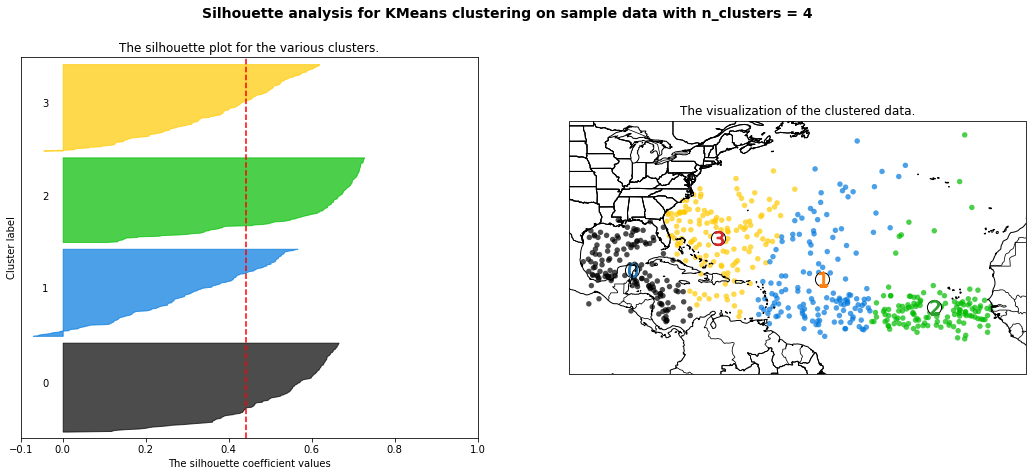

In [154]:

import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(18, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2, projection=ccrs.PlateCarree())

#The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(genesis_data) + (ncluster + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=ncluster, random_state=10)
cluster_labels = clusterer.fit_predict(genesis_data)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(genesis_data, cluster_labels)
print(
    "For n_clusters =",
    ncluster,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(genesis_data, cluster_labels)

y_lower = 10
for i in range(ncluster):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / ncluster)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / ncluster)


ax2.scatter(
    genesis_data[:,1], genesis_data[:,0], marker="o", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 1],
    centers[:, 0],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[1], c[0], marker="$%d$" % i, alpha=1, s=200, edgecolor=None)

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

ax2.set_extent([-100, -10, 0, 50], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND, color='white')
ax2.add_feature(cfeature.STATES)
ax2.add_feature(cfeature.BORDERS, linewidth=0.75)
coast = cfeature.NaturalEarthFeature(
    category='physical',
    name='coastline',
    scale='50m',
    facecolor='none'
)
ax2.add_feature(coast, edgecolor='black')
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='110m'
)
ax2.add_feature(states_provinces, linewidth=0.75, edgecolor='k', facecolor='none')

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % ncluster,
    fontsize=14,
    fontweight="bold",
)

plt.show()

In [155]:
# Add a 'Month' column to the genesis_lat_lon dataframe
genesis_lat_lon['Month'] = pd.to_datetime(genesis_lat_lon['ISO_TIME']).dt.month

# Add the cluster labels to the genesis_lat_lon dataframe
genesis_lat_lon['Cluster'] = labels

# Group by 'Cluster' and 'Month' and count the occurrences
month_distribution = genesis_lat_lon.groupby(['Cluster', 'Month']).size().unstack(fill_value=0)

print(month_distribution)

Month    1   4   5   6   7   8   9   10  11  12
Cluster                                        
0         0   0   5  23  12  30  32  34   7   1
1         0   0   0   2   9  49  66   8   1   2
2         1   1   8   9  20  27  40  25   8   1
3         0   1   1   4  11  43  45  24  11   1


## Homogeneity Evaluation

In [156]:
from sklearn.metrics import homogeneity_score

# Assuming 'labels' are the true labels and 'cluster_labels' are the predicted labels
homogeneity = homogeneity_score(genesis_lat_lon['Cluster'], cluster_labels)
print(f"Homogeneity Score: {homogeneity}")

Homogeneity Score: 1.0


In [157]:
from sklearn.metrics import fowlkes_mallows_score

# Assuming 'labels' are the true labels and 'cluster_labels' are the predicted labels
fmi = fowlkes_mallows_score(genesis_lat_lon['Cluster'], cluster_labels)
print(f"Fowlkes-Mallows Index: {fmi}")

Fowlkes-Mallows Index: 1.0


According to the homogeneity score and Fowlkes-Mallows Index the clusters perfectly labelled.

## Visualize the breakdown of clusters by month

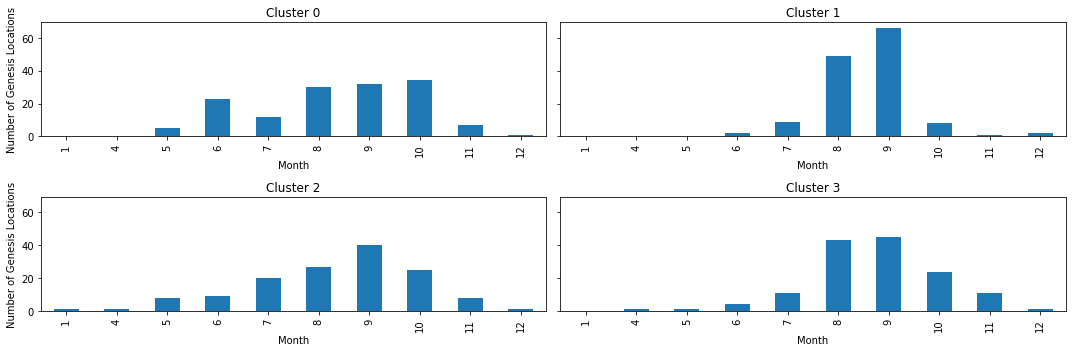

In [158]:
# Plot month distribution for each cluster on separate bar graphs
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5), sharey=True)

for i, ax in enumerate(axes.flatten()):
    month_distribution.loc[i].plot(kind='bar', ax=ax)
    ax.set_title(f'Cluster {i}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Number of Genesis Locations')

plt.tight_layout()
plt.show()

During the peak of the TC season most storms originate in the North East and Central Atlantic (Clusters 1 and 3). Howeever, later and early storms favor the Gulf of Mexico and the Caribbean (Cluster 0). Some late season storm also favor the North East Atlantic (Cluster 3).  Our results reveled that there are some ovelaps within the clusters. Nevertheless visualizing the breakdown of clusters by month shows that the clusters agree well with the expected starting point of cyclones during each month in the season.

This analysis revealed that cluster analysis may be challenging for data points that are very close to each other. Initially there were too many samples so we decided to focus on where the TC originate from. This allowed us to reduce the sample data significantly. The combination of the Elbow method informed us of the number of initial number of cluster that may be most appropriate. However the Silhoutte analysis revealed that our clusters may have some overlap. This is another drawback of cluster analysis. We did try to vary the number of cluster but there was no significant change.

## Repeated K-Means (30 Times)

In [140]:
N = 30
k = 3  # Define the value of k which is the number of clusters
(clusters, objective, centers) = repeat_kmeans(genesis_data, k, N)


0.0
3.3333333333333335
6.666666666666667
10.0
13.333333333333334
16.666666666666664
20.0
23.333333333333332
26.666666666666668
30.0
33.33333333333333
36.666666666666664
40.0
43.333333333333336
46.666666666666664
50.0
53.333333333333336
56.666666666666664
60.0
63.33333333333333
66.66666666666666
70.0
73.33333333333333
76.66666666666667
80.0
83.33333333333334
86.66666666666667
90.0
93.33333333333333
96.66666666666667


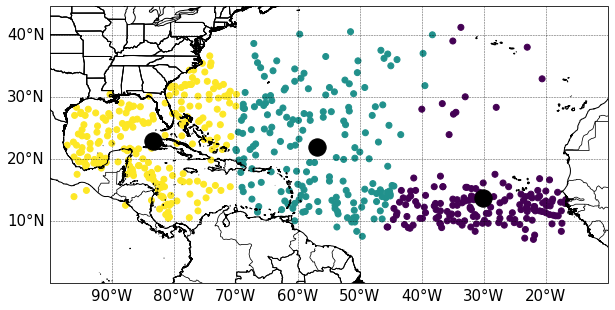

In [142]:
min_lat = 0
max_lat = 35

min_lon = -100
max_lon = -10

proj = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale='high', levels=[1,], edgecolor='k')
lakes = cfeature.GSHHSFeature(scale='high', levels=[2,], edgecolor='face',facecolor='grey')

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.set_extent([min_lon,max_lon, min_lat, max_lat])
ax.add_feature(cfeature.LAND, color='white')
ax.add_feature(cfeature.STATES)
ax.add_feature(coast)
ax.add_feature(cfeature.BORDERS, linewidth=0.75)
states_provinces = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='110m')

ax.add_feature(states_provinces, linewidth=0.75, edgecolor='k', facecolor='none')


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=0.5, color='k', alpha=0.7, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 10))
gl.ylocator = mticker.FixedLocator(np.arange(-90, 90, 10))
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

plt.scatter(genesis_data[:,1], genesis_data[:,0], c=clusters)
ax.scatter(centers[:, 1], centers[:, 0], marker='o', s=300, c='black', zorder=300)

# Add a color bar
# cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.05)
# cbar.set_label('Cluster')

plt.show()

